In [1]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing import *
from NPI import *
from group_analysis import *
from connectivity import *


# Import Connectome and Atlas data

In [2]:
# Define base path (adjust depending on where you run the notebook)
base_dir = os.path.abspath('..')  # go one level up from /notebooks
data_dir = os.path.join(base_dir, 'data', 'connectome')

# Load .mat files
#path_AAL = os.path.join(data_dir, 'AAL_labels_complete_symmetric.mat')
path_PET = os.path.join(data_dir, 'Hansen_NM_PET_Maps.mat')
path_RSN = os.path.join(data_dir, 'RSNsAAL_non-symmetric.mat')
path_SC  = os.path.join(data_dir, 'SC.mat')

#AAL_labels = loadmat(path_AAL)
PET_maps   = loadmat(path_PET)
RSNsAAL    = loadmat(path_RSN)
SC_mat         = loadmat(path_SC)

# Quick check of the variables inside each file
#print("AAL_labels keys:", AAL_labels.keys())
print("PET_maps keys:", PET_maps.keys())
print("RSNsAAL keys:", RSNsAAL.keys())
print("SC keys:", SC_mat.keys())

PET_maps keys: dict_keys(['__header__', '__version__', '__globals__', 'Maps_Labels', 'NM_PET_Maps'])
RSNsAAL keys: dict_keys(['__header__', '__version__', '__globals__', 'Yeo_AAL'])
SC keys: dict_keys(['__header__', '__version__', '__globals__', 'C'])


In [25]:
# Resting State Networks
RSNs_labels = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal-VentAttn', 'Limbic', 'Control', 'Default']

RSN_probs=RSNsAAL['Yeo_AAL']
RSN_probs=RSN_probs.astype(float)
for i in range(7):
    RSN_probs[i]=RSN_probs[i]/np.max(RSN_probs[i])
    
# 1. Assign each ROI to the RSN with maximum probability (0–6)
RSNs_max_prob = np.argmax(RSN_probs, axis=0)  # shape (90,)
# 2. Reorder ROIs so that all Left (L) come before Right (R) as in [L0, L1, ..., LN, RN, ...,R1, R0]
L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
RSNs = np.concatenate([RSNs_max_prob[L_ids], RSNs_max_prob[R_ids][::-1]])
RSNs

array([2, 6, 4, 5, 4, 3, 5, 4, 3, 3, 4, 6, 6, 4, 3, 6, 3, 6, 6, 4, 4, 0,
       0, 0, 0, 0, 0, 4, 1, 2, 2, 3, 6, 2, 1, 4, 0, 0, 0, 1, 1, 4, 6, 4,
       4, 4, 4, 6, 4, 1, 1, 0, 0, 3, 4, 1, 2, 6, 3, 5, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 4, 4, 4, 6, 3, 6, 3, 4, 6, 6, 4, 3, 3, 4, 5, 3, 5, 5, 4,
       6, 1])

In [26]:
RSNsAAL['Yeo_AAL'].shape

(7, 90)

In [27]:
# labels to sort by RSNs
order=np.argsort(RSNs, kind='stable')
order_mat=np.ix_(order,order)
RSN_ordered = RSNs[order] 
RSN_ordered

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6])

In [18]:
# Load the CSV
df_aal = pd.read_csv(data_dir+'/aal.csv', header=None)

ROIs_labels = df_aal.iloc[:, 0].astype(str).str.strip().tolist()

print(f"Loaded {len(ROIs_labels)} ROI labels")
print("Example:", ROIs_labels[:10])

Loaded 90 ROI labels
Example: ['L Precentral', 'L Frontal Sup', 'L Front Sup Orb', 'L Front Mid', 'L Front Mid Orb', 'L Front Inf Ope', 'L Front Inf Tri', 'L Front Inf Orb', 'L Rolandic Oper', 'L Supp Motor Ar']


In [19]:
# Structural Connectivity
SC=SC_mat['C']

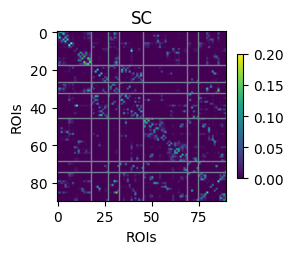

In [20]:
plt.figure(figsize=(3,3,))
plt.imshow(SC[order_mat].T)
plt.colorbar(shrink=0.5)
plt.title('SC')
plt.xlabel('ROIs')
plt.ylabel('ROIs')

# --- compute boundaries between networks ---
boundaries = np.where(np.diff(RSN_ordered) != 0)[0] + 1
# --- draw separator lines ---
for b in boundaries:
    plt.axhline(b - 0.5, color='slategray', lw=1)
    plt.axvline(b - 0.5, color='slategray', lw=1)
    
plt.tight_layout()
plt.show()

In [21]:
# Extract labels and flatten to clean strings
labels = [str(l[0]) for l in PET_maps['Maps_Labels'].squeeze()]
maps = PET_maps['NM_PET_Maps'][:, :90]  # shape (19, 90)

L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
ordr=np.hstack((L_ids,R_ids[::-1]))
maps=maps[:,ordr]

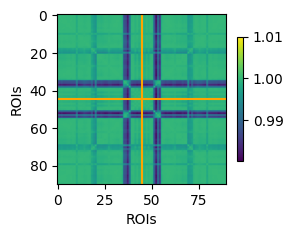

In [22]:
plt.figure(figsize=(3,3,))
plt.imshow(np.corrcoef(maps.T),vmax=1.01)
plt.axhline(45-0.5,c='orange')
plt.axvline(45-0.5,c='orange')
plt.colorbar(shrink=0.5)
plt.xlabel('ROIs')
plt.ylabel('ROIs')
plt.tight_layout()
plt.show()

In [23]:
# Create dict: {label: (90,) array}
PET_dict = {label: maps[i, :] for i, label in enumerate(labels)}

In [24]:
PET_dict.keys()

dict_keys(['5HT1a', '5HT1b', '5HT2a', '5HT4', '5HT6', '5HTT', 'A4B2', 'CB1', 'D1', 'D2', 'DAT', 'GABAa', 'H3', 'M1', 'mGluR5', 'MOR', 'NET', 'NMDA', 'VAChT'])

In [25]:
PET_dict['5HT1a'].shape

(90,)

# Import fMRI data

In [26]:
# build the path relative to your notebook
file_path = os.path.join("../data/fmri/ts_coma24_AAL_symm.mat")

# Path to your file
#file_path = os.path.join("..", "data", "fmri", "ts_coma24_AAL_symm.mat")

# Load the .mat file
mat_data = sio.loadmat(file_path)

# Inspect available keys (variables inside the .mat file)
print("Keys in .mat file:", mat_data.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'timeseries_CNT24_symm', 'timeseries_MCS24_symm', 'timeseries_UWS24_symm'])


In [27]:
# Path
file_path = os.path.join("..", "data", "fmri", "ts_coma24_AAL_symm.mat")

# Load
mat_data = sio.loadmat(file_path)

# Extract groups
ts_controls = mat_data["timeseries_CNT24_symm"]
ts_mcs      = mat_data["timeseries_MCS24_symm"]
ts_uws      = mat_data["timeseries_UWS24_symm"]

print("Controls:", ts_controls.shape)
print("MCS:", ts_mcs.shape)
print("UWS:", ts_uws.shape)

Controls: (1, 13)
MCS: (1, 11)
UWS: (1, 10)


In [28]:
# Unpack each group
controls = unpack_group(ts_controls)
mcs      = unpack_group(ts_mcs)
uws      = unpack_group(ts_uws)

# --- add preprocessing (k=2 Butterworth 0.01–0.08 Hz) plus zscore ---
controls = preprocess_groups(controls)
mcs      = preprocess_groups(mcs)
uws      = preprocess_groups(uws)

print(f"Controls: {len(controls)} subjects → subj[0] shape {controls[0].shape}")
print(f"MCS:      {len(mcs)} subjects → subj[0] shape {mcs[0].shape}")
print(f"UWS:      {len(uws)} subjects → subj[0] shape {uws[0].shape}")


Controls: 13 subjects → subj[0] shape (192, 90)
MCS:      11 subjects → subj[0] shape (192, 90)
UWS:      10 subjects → subj[0] shape (192, 90)


In [29]:
T=mcs[0].shape[0]   # time points
N=mcs[0].shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

In [30]:
groups = {"CNT": controls, "MCS": mcs, "UWS": uws}
groups_id = list(groups.keys())

In [31]:
cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
markers = {"CNT": "o", "MCS": "s", "UWS": "^"}